In [47]:
# Commands for notebook to reload library files
%load_ext autoreload
%autoreload 2

# Add src folder as a module to import library code
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.pardir, "src")))


# Models and analytical tools
import torch
from transformers import AutoTokenizer, EsmForProteinFolding

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

# Dimentionality reduction tools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#  Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Local libraries
import lib.analysis as als
import lib.plot as plot
import lib.utils as utils

# Reload cached libraries
import importlib
importlib.reload(als)
importlib.reload(plot)
importlib.reload(utils)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'lib.utils' from '/Users/sofar03/Code/python/protein-structural-similarity/src/lib/utils.py'>

In [48]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [49]:
protein_dir = os.environ.get('PROTEIN_DB_PATH', default=os.path.abspath(os.path.join(os.pardir, "protein_db")))
os.environ['PROTEIN_DB_PATH'] = protein_dir
protein_dir

'/Users/sofar03/Code/python/protein-structural-similarity/protein_db'

In [50]:
device = torch.device("cpu")
print(device)

cpu


# ESM Model

In [51]:
def tokenize(input):
    tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
    return tokenizer(input, return_tensors="pt", add_special_tokens=False).to(device)

In [52]:
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1").to(device)

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

#### Max model parameters

In [ ]:
with torch.no_grad():
    with open("esm3b_parameters_max.txt", "w") as f:
        for p in model.named_parameters():
            layer_name = p[0]
            layer_values = p[1].numpy()
            max_value_idx = np.unravel_index(np.argmax(layer_values), layer_values.shape)
            max_value = layer_values[max_value_idx]
            f.write(f'Max value of layer {layer_name} at index {max_value_idx}: {max_value}')
            f.write('\n')

#### Min model parameters

In [ ]:
with torch.no_grad():
    with open("esm3b_parameters_min.txt", "w") as f:
        for p in model.named_parameters():
            layer_name = p[0]
            layer_values = p[1].numpy()
            min_value_idx = np.unravel_index(np.argmin(layer_values), layer_values.shape)
            min_value = layer_values[min_value_idx]
            f.write(f'Min value of layer {layer_name} at index {min_value_idx}: {min_value}')
            f.write('\n')

### Protein 1

In [153]:
# >1F7D_1|Chains A, B|POL POLYPROTEIN|Feline immunodeficiency virus (11673)
# seq1 = ["MIIEGDGILDKRSEDAGYDLLAAKEIHLLPGEVKVIPTGVKLMLPKGYWGLIIGKSSIGSKGLDVLGGVIDEGYRGEIGVIMINVSRKSITLMERQKIAQLIILPCKHEVLEQGKVVMDSERGDNGYGSTGVFSSW"]
# seq1_name = "1F7D_1"

# >1DBW_1|Chains A, B|TRANSCRIPTIONAL REGULATORY PROTEIN FIXJ|Sinorhizobium meliloti (382)
# seq1 = ["MQDYTVHIVDDEEPVRKSLAFMLTMNGFAVKMHQSAEAFLAFAPDVRNGVLVTDLRMPDMSGVELLRNLGDLKINIPSIVITGHGDVPMAVEAMKAGAVDFIEKPFEDTVIIEAIERASEHLVALE"]
# seq1_name = "1DBW_1"

# >5YCI_1|Chains A, B|Ancestral myoglobin aMbWb' of Basilosaurus relative (polyphyly)|Physeter catodon (9755)
# seq1 = ["GSHMGLSDGEWQLVLNIWGKVEADVAGHGQDVLIRLFKGHPETLEKFDKFKHLKTEAEMKASEDLKKHGNTVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISDAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGFQG"]
# seq1_name = "5YCI_1"

# >1V6C_1|Chains A, B|alkaline serine protease|Pseudoalteromonas sp. (247492)
# seq1 = ["AETTPWGQTFVGATVLSDSQAGNRTICIIDSGYDRSHNDLNANNVTGTNNSGTGNWYQPGNNNAHGTHVAGTIAAIANNEGVVGVMPNQNANIHIVKVFNEAGWGYSSSLVAAIDTCVNSGGANVVTMSLGGSGSTTTERNALNTHYNNGVLLIAAAGNAGDSSYSYPASYDSVMSVAAVDSNLDHAAFSQYTDQVEISGPGEAILSTVTVGEGRLADITIGGQSYFSNGVVPHNRLTPSGTSYAPAPINASATGALAECTVNGTSFSCGNMANKICLVERVGNQGSSYPEINSTKACKTAGAKGIIVYSNSALPGLQNPFLVDANSDITVPSVSVDRATGLALKAKLGQSTTVSNQGNQDYEYYNGTSMATPHVSGVATLVWSYHPECSASQVRAALNATADDLSVAGRDNQTGYGMINAVAAKAYLDESCTGPTDPGTG"]
# seq1_name = "1V6C_1"

# >8B9V_1|Chain A[auth L]|Lu AF82422 Fab light chain|Homo sapiens (9606)
seq1 = ["EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPWTFGQGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGEC"]
seq1_name = "8B9V_1"

# >2WPO_1|Chains A, B, C, D|HUMAN CYTOMEGALOVIRUS PROTEASE|Human herpesvirus 5 (10359)
# seq1 = ["MTMDEQQSQAVAPVYVGGFLARYDQSPDEAELLLPRDVVEHWLHAQGQGQPSLSVALPLNINHDDTAVVGHVAAMQSVRDGLFCLGCVTSPRFLEIVRRASEKSELVSRGPVSPLQPDKVVEFLSGSYAGLSLSSRRCDDVEQATSLSGSETTPFKHVALCSVGRRRGTLAVYGRDPEWVMQRFPDLTAADRDGLRAQWQRCGSTAVDASGDPFRSDSYGLLGNSVDAMYIRERLPKLRYDKQLVGVTERESYVKA"]
# seq1_name = "2WPO_1"

input1 = tokenize(seq1).to(device)
input1["input_ids"].shape


torch.Size([1, 215])

### Protein 2

In [154]:
# >1QHO_1|Chain A|ALPHA-AMYLASE|Geobacillus stearothermophilus (1422)
# seq2 = ["SSSASVKGDVIYQIIIDRFYDGDTTNNNPAKSYGLYDPTKSKWKMYWGGDLEGVRQKLPYLKQLGVTTIWLSPVLDNLDTLAGTDNTGYHGYWTRDFKQIEEHFGNWTTFDTLVNDAHQNGIKVIVDFVPNHSTPFKANDSTFAEGGALYNNGTYMGNYFDDATKGYFHHNGDISNWDDRYEAQWKNFTDPAGFSLADLSQENGTIAQYLTDAAVQLVAHGADGLRIDAVKHFNSGFSKSLADKLYQKKDIFLVGEWYGDDPGTANHLEKVRYANNSGVNVLDFDLNTVIRNVFGTFTQTMYDLNNMVNQTGNEYKYKENLITFIDNHDMSRFLSVNSNKANLHQALAFILTSRGTPSIYYGTEQYMAGGNDPYNRGMMPAFDTTTTAFKEVSTLAGLRRNNAAIQYGTTTQRWINNDVYIYERKFFNDVVLVAINRNTQSSYSISGLQTALPNGSYADYLSGLLGGNGISVSNGSVASFTLAPGAVSVWQYSTSASAPQIGSVAPNMGIPGNVVTIDGKGFGTTQGTVTFGGVTATVKSWTSNRIEVYVPNMAAGLTDVKVTAGGVSSNLYSYNILSGTQTSVVFTVKSAPPTNLGDKIYLTGNIPELGNWSTDTSGAVNNAQGPLLAPNYPDWFYVFSVPAGKTIQFKFFIKRADGTIQWENGSNHVATTPTGATGNITVTWQN"]
# seq2_name = "1QHO_1"

# >2QWV_1|Chains A, B|UPF0217 protein VC_A1059|Vibrio cholerae O1 biovar eltor str. N16961 (243277)
# seq2 = ["SNAMRNTMRSFILRARSAPTDSQRLLDEIGGKCHTEILAHCMMNSLFTAQSHREDVVIHLVLESTRDYSRTITVEANEISDVGGFHEAALIALLVKALDASVGMGKEQTRVVQPGLTVRTISFEALLGELAEHHSLYMMDKKGDSIRDIKIGPNPCFILTDHIPMPKKSGNSMKRLGVEKISLGPKMLFASQCVTLIHNEIDHQEAGW"]
# seq2_name = "2QWV_1"

# >1AZI_1|Chain A|MYOGLOBIN|Equus caballus (9796)
# seq2 = ["GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKFKHLKTEAEMKASEDLKKHGTVVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISDAIIHVLHSKHPGDFGADAQGAMTKALELFRNDIAAKYKELGFQG"]
# seq2_name = "1AZI_1"

# >1R0R_1|Chain A[auth E]|subtilisin carlsberg|Bacillus licheniformis (1402)
# seq2 = ["AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ"]
# seq2_name = "1ROR_1"

# >8B9V_2|Chain B[auth H]|Lu AF82422 Fab heavy chain|Homo sapiens (9606)
seq2 = ["EVQLLESGGGLVQTGGSLRLSCAASGFTFSSYAMTWVRQAPGKGLEWVSAIRSQGDRTDYADSVKGRFTISRDNSQNTLYLQMNSLRAEDTAVYYCAKNWAPFDSWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEPK"]
seq2_name = "8B9V_2"

# >7AL8_1|Chains A[auth B], C[auth E], E[auth H], G[auth K], I[auth N], K[auth Q], M[auth T], O[auth U]|Cationic trypsin|Bos taurus (9913)
# seq2 = ["IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGIQVRLGEDNINVVEGNEQFISASKSIVHPSYNSNTLNNDIMLIKLKSAASLNSRVASISLPTSCASAGTQCLISGWGNTKSSGTSYPDVLKCLKAPILSDSSCKSAYPGQITSNMFCAGYLEGGKDSCQGDSGGPVVCSGKLQGIVSWGSGCAQKNKPGVYTKVCNYVSWIKQTIASN"]
# seq2_name = "7AL8_1"

input2 = tokenize(seq2).to(device)
input2["input_ids"].shape

torch.Size([1, 217])

### Protein 3

In [ ]:
# >1MEE_1|Chain A|MESENTERICOPEPTIDASE|Bacillus pumilus (1408)
seq3 = ["AQSVPYGISQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLNVRGGASFVPSETNPYQDGSSHGTHVAGTIAALNNSIGVLGVAPSASLYAVKVLDSTGSGQYSWIINGIEWAISNNMDVINMSLGGPTGSTALKTVVDKAVSSGIVVAAAAGNEGSSGSTSTVGYPAKYPSTIAVGAVNSANQRASFSSAGSELDVMAPGVSIQSTLPGGTYGAYNGTSMATPHVAGAAALILSKHPTWTNAQVRDRLESTATYLGSSFYYGKGLINVQAAAQ"]
seq3_name = "1MEE_1"

input3 = tokenize(seq3).to(device)
input3["input_ids"].shape

In [ ]:
seq3[0][56]

### Structural Prediction

In [168]:
def predict(input):
    with torch.no_grad():
        return model(**input)

In [ ]:
out1 = predict(input1)

In [83]:
out2 = predict(input2)

In [ ]:
out3 = predict(input3)

### Sequence Prediction

In [ ]:
def sequence_prediction(input):
    with torch.no_grad():
        attention = torch.ones_like(input['input_ids']).to(device)
        m_esm_a = model.af2_idx_to_esm_idx(input['input_ids'], attention)
        m_esm_s = model.compute_language_model_representations(m_esm_a)
        return m_esm_a, m_esm_s

In [ ]:
m_esm_a2, m_esm_s2 = sequence_prediction(input2)
m_esm_s2 = m_esm_s2.squeeze(0)

In [ ]:
m_esm_a3, m_esm_s3 = sequence_prediction(input3)
m_esm_s3 = m_esm_s3.squeeze(0)

In [ ]:
m_esm_s2.shape

### Infer PDB

In [ ]:
with torch.no_grad():
    pdb = model.infer_pdb(seq1[0])

In [ ]:
with open(f'../pdb/{seq1_name}.pdb', "w") as f:
    f.write(pdb)

### Load embeddings

In [170]:
def load_embeddings(seq_name, type="seq"):
    if utils.embeddings_exist(seq_name, type):
        return utils.read_embeddings(seq_name, type)
    else:
        out = predict(input1)
        if type == "seq":
            emb = out['s_s'].cpu().numpy().squeeze(0)
            utils.save(data=emb, name=utils.embeddings_path(seq_name, emb.shape))
            return emb
        else:
            emb = out['s_z'].cpu().numpy().squeeze(0)
            als.save(data=emb.reshape(-1, emb.shape[2]), name=utils.embeddings_path(seq1_name, emb.shape, "pair"))
            return emb

#### Sequence

In [171]:
emb1 = load_embeddings(seq1_name)

Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_1/seq*
Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_1/seq*


In [172]:
emb2 = load_embeddings(seq2_name)

Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_2/seq*
Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_2/seq*


In [173]:
emb3 = load_embeddings(seq3_name)

NameError: name 'seq3_name' is not defined

#### Pairwise

In [174]:
pair_emb1 = load_embeddings(seq1_name, type="pair")

Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_1/pair*
Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_1/pair*


In [175]:
pair_emb2 = load_embeddings(seq2_name, type="pair")

Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_2/pair*
Looking for embeddings in path: /Users/sofar03/Code/python/protein-structural-similarity/protein_db/esm/embeddings/8B9V_2/pair*


In [ ]:
pair_emb3 = load_embeddings(seq3_name, type="pair")

# Experiments

## Per-residue embeddings

### Analysis

In [176]:
norm_emb1 = als.normalized_z_score(emb1)
norm_emb2 = als.normalized_z_score(emb2)

In [177]:
min_max_emb1 = np.array([als.remove_min_max(e, iterations=4) for e in emb1])
min_max_emb2 = np.array([als.remove_min_max(e, iterations=4) for e in emb2])

In [178]:
protein_corr = als.protein_correlation(emb1.T, emb2.T, window=20)

In [180]:
self_corr = als.protein_correlation(emb1.T, emb1.T, window=10)

In [ ]:
norm_protein_corr = als.protein_correlation(norm_emb1, norm_emb2, window=10)

In [ ]:
min_max_protein_corr = als.protein_correlation(min_max_emb1.T, min_max_emb2.T, window=10)

In [186]:
autocorr_emb1 = np.array([als.autocorr(e, normalize=True) for e in emb1.T]).squeeze(-2)
autocorr_emb2 = np.array([als.autocorr(e, normalize=True) for e in emb2.T]).squeeze(-2)

In [ ]:
autocorr_norm_emb1 = np.array([als.autocorr(e, normalize=True) for e in norm_emb1.T]).squeeze(1)
autocorr_norm_emb2 = np.array([als.autocorr(e, normalize=True) for e in norm_emb2.T]).squeeze(1)

### Plots

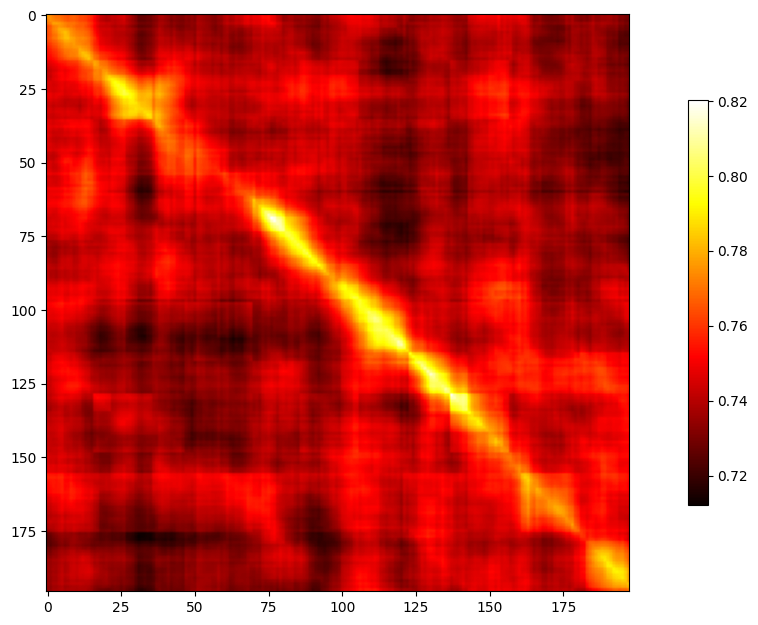

In [183]:
plot.heatmap2d(np.mean(protein_corr, axis=0), scale=1.5)

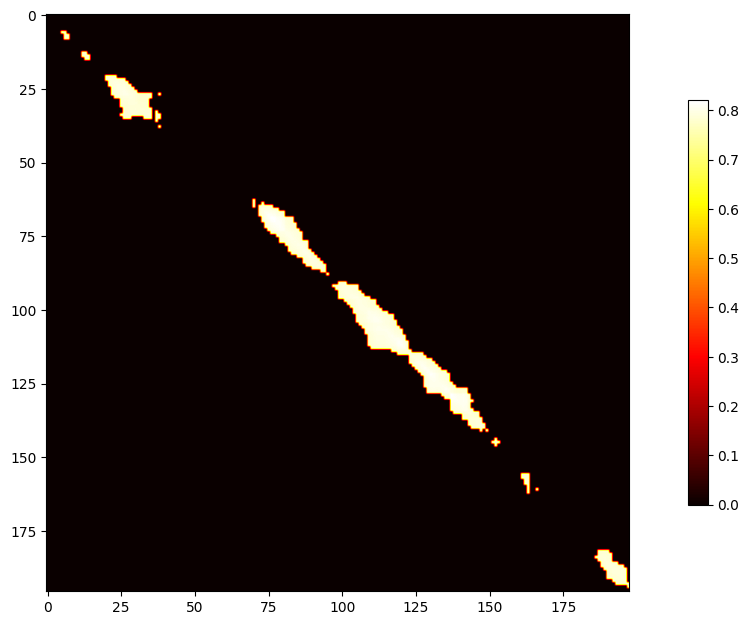

In [184]:
plot.heatmap2d(als.filter(np.mean(protein_corr, axis=0), 0.78), scale=1.5)

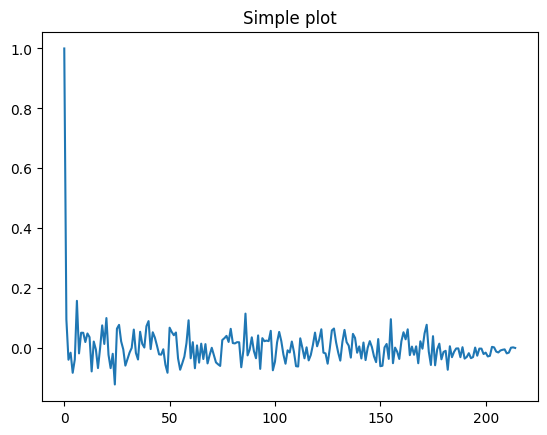

In [187]:
plot.simple_plot(autocorr_emb1[65])

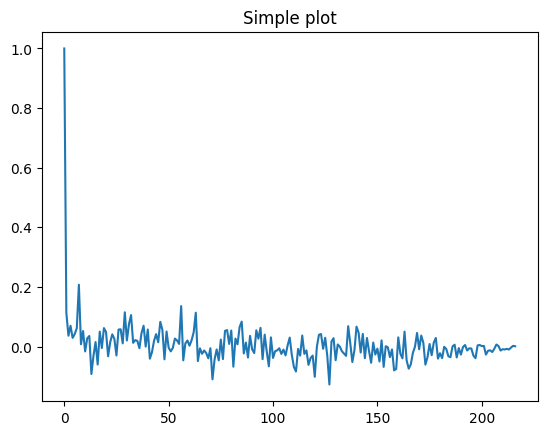

In [188]:
plot.simple_plot(autocorr_emb2[2])

In [192]:
cossim3 = cosine_similarity(min_max_emb1, min_max_emb2)

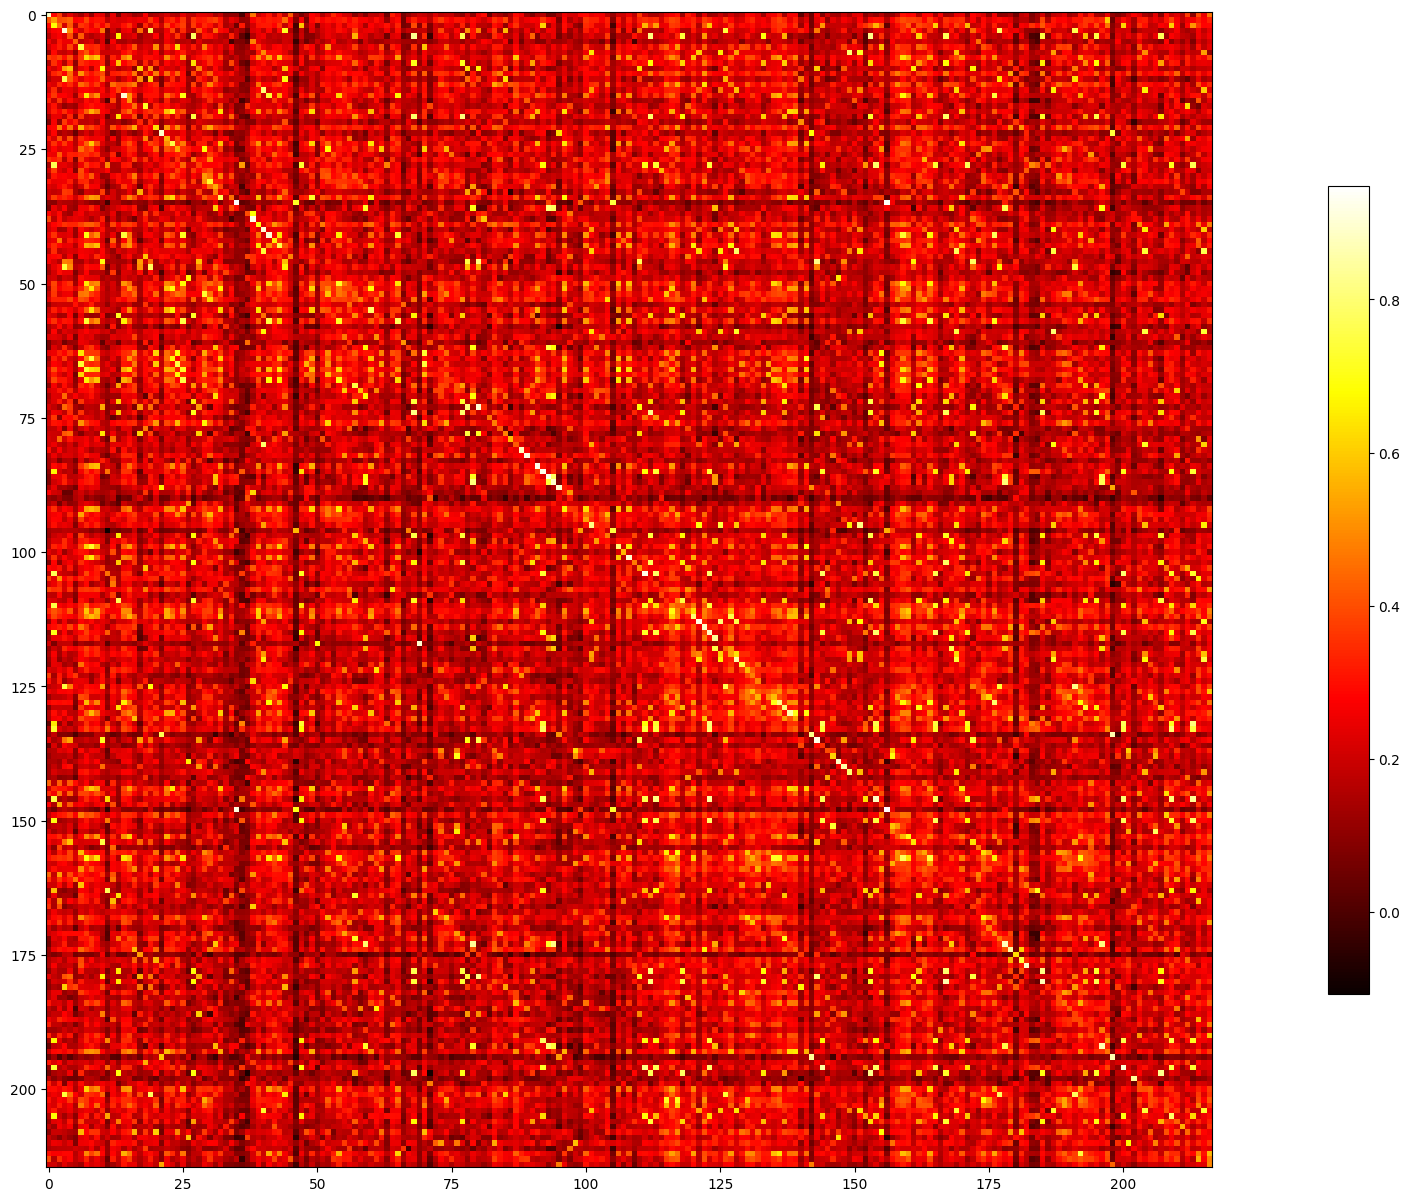

In [194]:
plot.heatmap2d(cossim3, scale=3)

## Pairwise residue embeddings

### Analysis

In [ ]:
pair_sim1 = als.cossim3d(pair_emb1)
pair_sim2 = als.cossim3d(pair_emb2)

### Plots

In [ ]:
plot.simple_plot(pair_emb1[40])

In [ ]:
plot.simple_plot(pair_emb2[35][35])

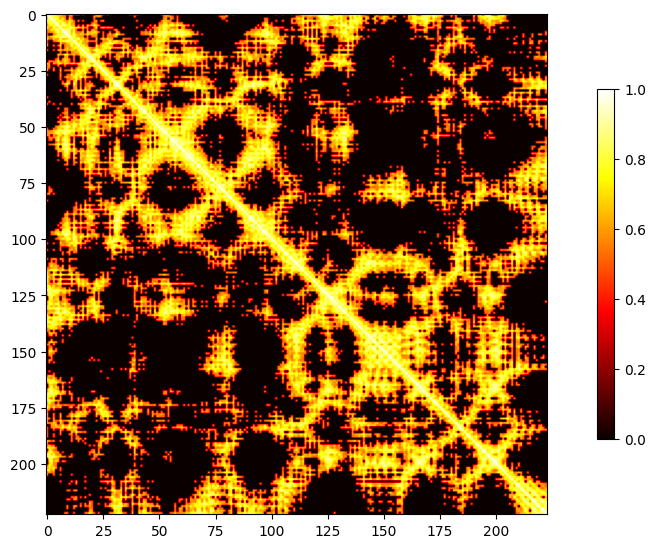

In [149]:
plot.heatmap2d(als.filter(np.median(pair_sim2, axis=0), 0.5), scale=1.3)

In [ ]:
plot.heatmap2d(als.highlight(als.filter(np.mean(pair_sim1, axis=0), 0.4), (16, 28)), scale=2)

In [ ]:
plot.heatmap2d(np.mean(pair_sim2, axis=0), scale=2)

In [ ]:
plot.heatmap2d(als.highlight(als.filter(np.mean(pair_sim2, axis=0), 0.4), (34, 46)), scale=2)

In [ ]:
plot.heatmap2d(np.mean(pair_sim2, axis=0)[33:42], scale=2)

In [ ]:
plot.simple_plot(pair_emb1[17, 0])

In [ ]:
plot.simple_plot(pair_emb2[41, 0])

In [ ]:
cosine_similarity(np.vstack((pair_emb1[23], pair_emb1[41])))

In [ ]:
pair_emb1[17][17:26].shape

In [ ]:
als.slice_of_slice(pair_emb1, (17,26), (17,26)).reshape((-1, 128)).shape

In [ ]:
pair_emb2[44]

In [ ]:
plot.heatmap2d(
    als.cossim(
        np.vstack(als.slice_of_slice(pair_emb1, (67,76), (67,76)).reshape((-1, 128))), 
        pair_emb2[100]
    ), scale=3
)

## Dimentionality reduction (PCA, t-SNE)

In [ ]:
tsne_result1 = als.umap(als.pca(min_max_emb1[0:20], components=16), components=2)
tsne_result2 = als.umap(als.pca(min_max_emb2[0:20], components=16), components=2)

In [ ]:
plot.scatter2d(tsne_result1)

In [ ]:
plot.scatter2d(tsne_result2)

In [ ]:
tsne_result1 = als.umap(als.pca(min_max_emb1, components=64), components=3)
tsne_result2 = als.umap(als.pca(min_max_emb2, components=64), components=3)

In [ ]:
pca_result1 = als.pca(emb1, components=2)
pca_result2 = als.pca(emb2, components=2)

In [ ]:
plot.scatter2d(np.vstack((min_max_emb1[50], min_max_emb2[50])).T)